In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

## Data Preparation for ARIMA models

In [2]:
pred_var = 'Additional_Doses_Vax_Pct'

In [20]:
df = pd.read_csv('df_post_eda.csv')

df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()
#df.set_index('Date', inplace=True)

#subset data to be only dates and predictin variable values
data = pd.DataFrame(df)

In [21]:
data.head()

,Additional_Doses_Vax_Pct
Date,
2021-11-03,10.332812
2021-11-10,13.185937
2021-11-17,15.871875
2021-11-24,18.675000
2021-12-01,20.689062


In [22]:
# checking if data is stationary
from statsmodels.tsa.stattools import adfuller

# Differencing the data
data_diff = data.diff().dropna()

# Perform the Augmented Dickey-Fuller test to check for stationarity
result = adfuller(data_diff)
p_value = result[1]

if p_value <= 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary. Further differencing may be required.")


The data is stationary.


In [23]:
data.head()

,Additional_Doses_Vax_Pct
Date,
2021-11-03,10.332812
2021-11-10,13.185937
2021-11-17,15.871875
2021-11-24,18.675000
2021-12-01,20.689062


In [24]:
# resambpling to weekly datetime to prevent convergence warnings
data = data.resample('W').sum()

In [25]:
# Split data into test and train

# Determine the split point (e.g., 70% for training, 30% for testing)
split_date = int(len(data) * 0.8)
data = data.sort_index(ascending=True)
# Split the data
train_data = data.iloc[:split_date]
test_data = data.iloc[split_date:]


In [26]:
data.head()

,Additional_Doses_Vax_Pct
Date,
2021-11-07,10.332812
2021-11-14,13.185937
2021-11-21,15.871875
2021-11-28,18.675000
2021-12-05,20.689062


In [27]:
train_data.head()

,Additional_Doses_Vax_Pct
Date,
2021-11-07,10.332812
2021-11-14,13.185937
2021-11-21,15.871875
2021-11-28,18.675000
2021-12-05,20.689062


In [28]:
test_data.head()

,Additional_Doses_Vax_Pct
Date,
2023-01-29,50.575000
2023-02-05,50.621875
2023-02-12,50.667187
2023-02-19,50.706250
2023-02-26,50.745312


## ARIMA MODEL

In [29]:
# fiting initial model without tunning

# Create and fit an ARIMA model on the training data
p = 1  # Order of the autoregressive (AR) component
d = 1  # Order of differencing
q = 1  # Order of the moving average (MA) component

model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

Root Mean Squared Error (RMSE): 0.3858283342055915


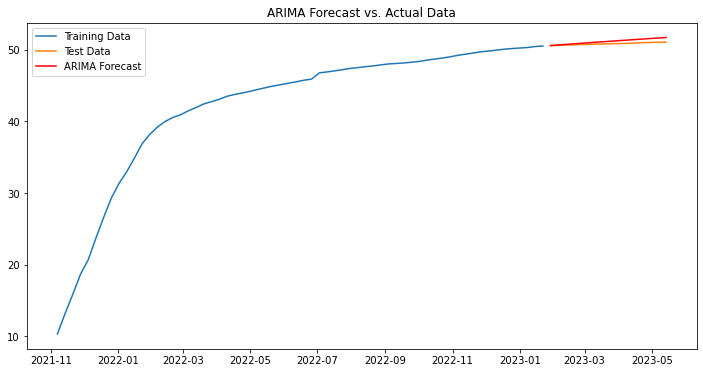

In [30]:
# Forecast future values using the ARIMA model
n_forecast = len(test_data)
forecast = model_fit.forecast(steps=n_forecast)

# Evaluate the model's performance
rmse = sqrt(mean_squared_error(test_data, forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")


# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(test_data.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs. Actual Data')
plt.show()

In [31]:
import warnings

# Suppress specific warning types
warnings.filterwarnings("ignore")

### p (AutoRegressive Order):
The "p" in ARIMA stands for the autoregressive order. It represents the number of lag observations included in the model. In other words, it indicates how many past time points should be considered to predict the current value. A higher value of p means that the model takes into account more past observations.
### d (Integrated Order):
The "d" in ARIMA stands for differencing. It represents the number of times the raw observations are differenced to achieve stationarity. Stationarity is a property of time series data where statistical properties, such as mean and variance, remain constant over time. Differencing helps in making the time series stationary by removing trends or seasonality.
### q (Moving Average Order):
The "q" in ARIMA stands for the moving average order. It represents the number of lagged forecast errors in the prediction equation. A moving average model uses past forecast errors to predict future values. The parameter q determines how many lagged forecast errors are included in the model. Similar to p, a higher value of q means that the model considers more past errors.

In [32]:
## tuning model

import itertools

p_values = range(0, 10)
d_values = range(0, 10)
q_values = range(0, 10)

best_rmse = float('inf')
best_order = (0, 0, 0)

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(train_data, order=(p, d, q))
        model_fit = model.fit()

        forecast = model_fit.forecast(steps=len(test_data))
        rmse = sqrt(mean_squared_error(test_data, forecast))

        if rmse < best_rmse:
            best_rmse = rmse
            best_order = (p, d, q)
    except:
        continue

print(f"Best ARIMA Order: {best_order} with RMSE: {best_rmse}")

Best ARIMA Order: (5, 0, 6) with RMSE: 0.039346660772371055


In [ ]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])  
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

Root Mean Squared Error (RMSE): 0.039346660772371055


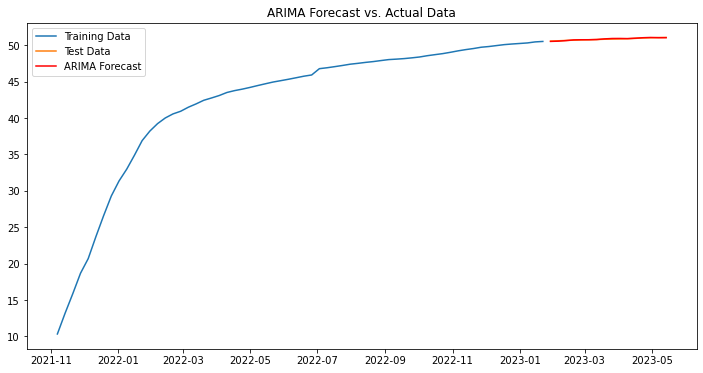

In [55]:
model = ARIMA(train_data, order=(5, 0, 6))
model_fit = model.fit()

# Forecast future values using the ARIMA model
n_forecast = len(test_data)
forecast = model_fit.forecast(steps=n_forecast)

# Evaluate the model's performance
rmse = sqrt(mean_squared_error(test_data, forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")


# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(test_data.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs. Actual Data')
plt.show()

In [ ]:
## different approach

In [49]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
# load dataset

df = read_csv('df_post_eda.csv')
series = df[['Date',pred_var]]
series = series.groupby('Date')[pred_var].mean()
series = series.to_frame()
#series = series.set_index('Date')
series.head()
#series.index = series.index.to_period('W')

,Additional_Doses_Vax_Pct
Date,
2021-11-03,10.332812
2021-11-10,13.185937
2021-11-17,15.871875
2021-11-24,18.675000
2021-12-01,20.689062


                                  SARIMAX Results                                   
Dep. Variable:     Additional_Doses_Vax_Pct   No. Observations:                   80
Model:                       ARIMA(5, 1, 0)   Log Likelihood                   4.178
Date:                      Sun, 12 Nov 2023   AIC                              3.645
Time:                              19:28:38   BIC                             17.862
Sample:                          11-03-2021   HQIC                             9.341
                               - 05-10-2023                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7570      0.067     11.266      0.000       0.625       0.889
ar.L2          0.2086      0.129      1.618      0.106      -0.044       0.461
ar.L

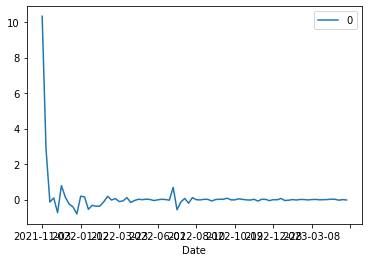

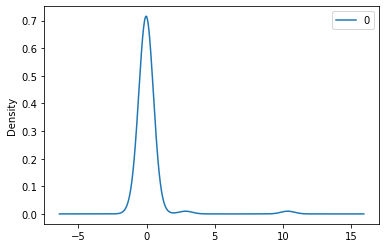

               0
count  80.000000
mean    0.128543
std     1.219274
min    -0.806042
25%    -0.053109
50%    -0.002891
75%     0.020361
max    10.332812


In [50]:
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

Iteration 64 - Best Parameters: (3, 0, 3), Final Forecast: 50.579740, Actual: 50.575000, Final RMSE: 0.00473970
Iteration 65 - Best Parameters: (2, 3, 1), Final Forecast: 50.621079, Actual: 50.621875, Final RMSE: 0.00079591
Iteration 66 - Best Parameters: (2, 1, 0), Final Forecast: 50.667604, Actual: 50.667187, Final RMSE: 0.00041666
Iteration 67 - Best Parameters: (2, 3, 0), Final Forecast: 50.706450, Actual: 50.706250, Final RMSE: 0.00020009
Iteration 68 - Best Parameters: (0, 2, 0), Final Forecast: 50.745313, Actual: 50.745312, Final RMSE: 0.00000000
Iteration 69 - Best Parameters: (1, 3, 1), Final Forecast: 50.770395, Actual: 50.767187, Final RMSE: 0.00320761
Iteration 70 - Best Parameters: (3, 1, 2), Final Forecast: 50.795257, Actual: 50.795313, Final RMSE: 0.00005583
Iteration 71 - Best Parameters: (0, 3, 0), Final Forecast: 50.829687, Actual: 50.832813, Final RMSE: 0.00312500
Iteration 72 - Best Parameters: (1, 3, 2), Final Forecast: 50.856930, Actual: 50.857813, Final RMSE: 0.0

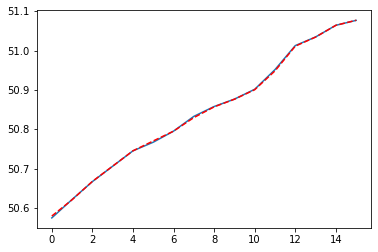

In [81]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Convert the series to an array
X = series.values

# Set the order ranges for the ARIMA model parameters
p_range = range(0, 4)  # Adjust as needed
d_range = range(0, 4)  # Adjust as needed
q_range = range(0, 4)  # Adjust as needed

# Number of observations to use for training
size = int(len(X) * 0.8)

# Initialize an empty list to store forecast values
forecast_values = []

# Initialize an empty list to store RMSE values
rmse_values = []

# Walk-forward validation with parameter tuning
for t in range(size, len(X)):
    train, test = X[0:t], X[t:t+1]
    history = [x for x in train]
    best_rmse = float('inf')
    best_params = None

    # Iterate over parameter combinations
    for p in p_range:
        for d in d_range:
            for q in q_range:
                # Fit the ARIMA model
                model = ARIMA(history, order=(p, d, q))
                model_fit = model.fit()
                # Make a one-step forecast
                output = model_fit.forecast(steps=1)
                yhat = output[0]
                # Evaluate the forecast
                rmse = sqrt(mean_squared_error(test, [yhat]))
                # Update best parameters if the RMSE improves
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (p, d, q)

    # Use the best parameters to fit the final model and make the forecast
    final_model = ARIMA(history, order=best_params)
    final_model_fit = final_model.fit()
    final_output = final_model_fit.forecast(steps=1)
    final_yhat = final_output[0]

    # Append the last forecast value to the list
    forecast_values.append(final_yhat)

    # Append the RMSE of the final model to the list
    rmse_values.append(best_rmse)

    # Append the actual observation to the history for the next iteration
    history.append(test[0])

    print('Iteration %d - Best Parameters: %s, Final Forecast: %f, Actual: %f, Final RMSE: %.8f' % (
        t, best_params, final_yhat, test[0], best_rmse))

# Calculate the average RMSE
average_rmse = sum(rmse_values) / len(rmse_values)
print('Average Test RMSE: %.3f' % average_rmse)

# Plot actual outcomes and forecasts
plt.plot(X[size:])
plt.plot(forecast_values, color='red', linestyle='dashed')
plt.show()


# AUTOARIMA

In [13]:
from pmdarima import auto_arima

In [9]:
# adding lag variables
data['lag_1'] = data[pred_var].shift(1)
data['lag_2'] = data[pred_var].shift(2)
# Add more lag features as needed


In [18]:
# untuned
model = auto_arima(train_data, seasonal=False, stepwise=True, trace=True)


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=21.553, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=19.268, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=16.652, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=16.138, Time=0.01 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=18.945, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=18.138, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=18.138, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=19.912, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=17.556, Time=0.01 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 0.279 seconds


In [19]:
best_order = model.get_params()['order']

In [20]:
p, d, q = best_order
final_model = ARIMA(train_data, order=(p, d, q))
final_model_fit = final_model.fit()

Root Mean Squared Error (RMSE): 1.541922692173141


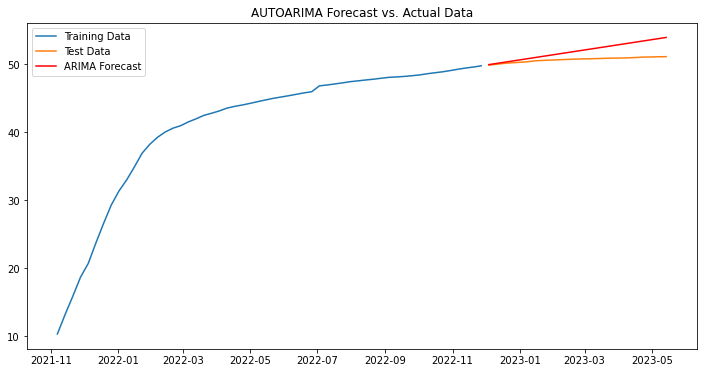

In [27]:
n_forecast = len(test_data)
forecast = final_model_fit.forecast(steps=n_forecast)
rmse = sqrt(mean_squared_error(test_data, forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(test_data.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

In [ ]:
#### TUNING

Root Mean Squared Error (RMSE): 1.541922692173141


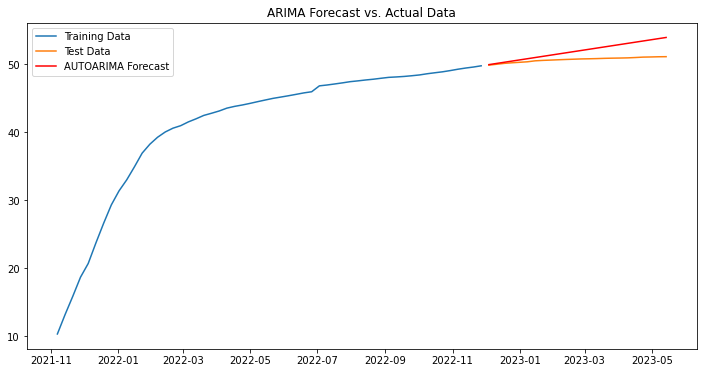

In [28]:
# seasonal = True
model = auto_arima(train_data, seasonal=True, m=12)
best_order = model.get_params()['order']
p, d, q = best_order
final_model = ARIMA(train_data, order=(p, d, q))
final_model_fit = final_model.fit()
n_forecast = len(test_data)
forecast = final_model_fit.forecast(steps=n_forecast)
rmse = sqrt(mean_squared_error(test_data, forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(test_data.index, forecast, label='AUTOARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs. Actual Data')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=29.168, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=126.033, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=30.259, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=93.621, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=28.498, Time=0.04 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=29.302, Time=0.09 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=31.136, Time=0.20 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=92.610, Time=0.02 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=29.539, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=30.267, Time=0.06 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=30.292, Time=0.06 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=69.478, Time=0.03 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=28.267, Time=0.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=29.049, Time=0.14 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=28.

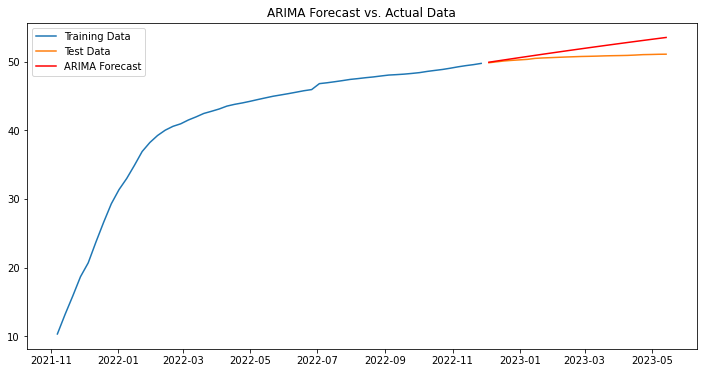

In [29]:
# seatch range
model = auto_arima(train_data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

best_order = model.get_params()['order']
p, d, q = best_order
final_model = ARIMA(train_data, order=(p, d, q))
final_model_fit = final_model.fit()
n_forecast = len(test_data)
forecast = final_model_fit.forecast(steps=n_forecast)
rmse = sqrt(mean_squared_error(test_data, forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(test_data.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs. Actual Data')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=29.168, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=126.033, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=30.259, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=93.621, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=28.498, Time=0.04 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=29.302, Time=0.08 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=31.136, Time=0.20 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=92.610, Time=0.02 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=29.539, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=30.267, Time=0.06 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=30.292, Time=0.05 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=69.478, Time=0.03 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=28.267, Time=0.04 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=29.049, Time=0.13 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=28.

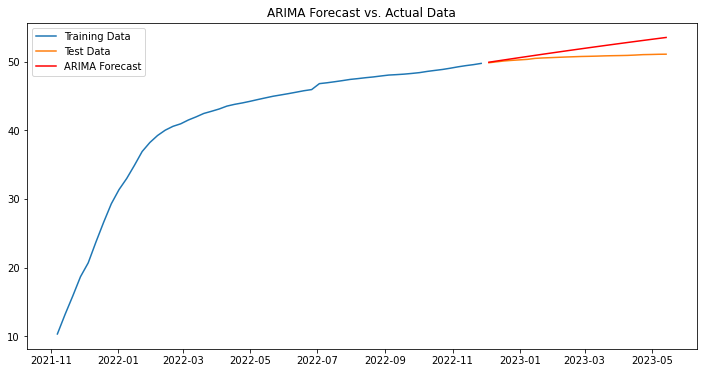

In [32]:
# seatch range
model = auto_arima(train_data, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

best_order = model.get_params()['order']
p, d, q = best_order
final_model = ARIMA(train_data, order=(p, d, q))
final_model_fit = final_model.fit()
n_forecast = len(test_data)
forecast = final_model_fit.forecast(steps=n_forecast)
rmse = sqrt(mean_squared_error(test_data, forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(test_data.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs. Actual Data')
plt.show()

In [33]:
# seasonal ARIMA
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=10.422, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=165.776, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=13.724, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=112.660, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=10.688, Time=0.05 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=12.272, Time=0.29 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=12.294, Time=1.82 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=10.768, Time=0.15 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=14.240, Time=2.25 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=13.304, Time=0.16 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=12.235, Time=0.20 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=12.134, Time=0.32 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=165.192, Time=0.08 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=76.665, Time=0.13 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=1

In [34]:
stepwise_model.fit(train_data)

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [35]:
test_data.shape

(24, 1)

In [36]:
future_forecast = stepwise_model.predict(n_periods=24)

In [45]:
future_forecast = pd.DataFrame(future_forecast,index = test_data.index,columns=['Prediction'])
df_auto_arima = pd.concat([test_data,future_forecast],axis=1)

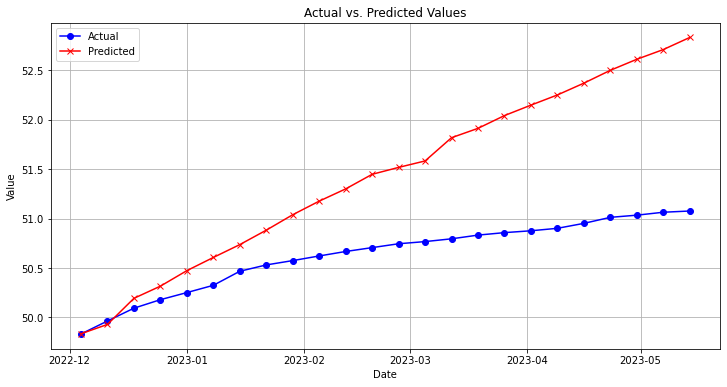

In [47]:
# Plot the actual values
plt.figure(figsize=(12, 6))
plt.plot(df_auto_arima.index, df_auto_arima['Additional_Doses_Vax_Pct'], label='Actual', marker='o', color='blue')

# Plot the predicted values
plt.plot(df_auto_arima.index, df_auto_arima['Prediction'], label='Predicted', marker='x', color='red')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


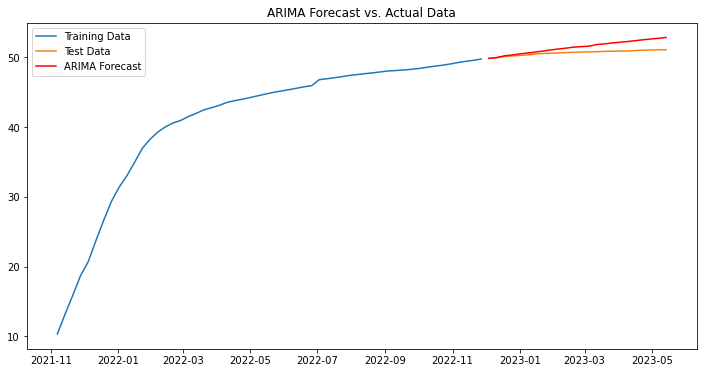

In [48]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(test_data.index, future_forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs. Actual Data')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24.495, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=149.114, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.482, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=105.838, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=173.869, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26.397, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26.412, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=75.475, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24.401, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=26.400, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=27.895, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.381 seconds
Root Mean Squared Error (RMSE): 1.3565442142747086


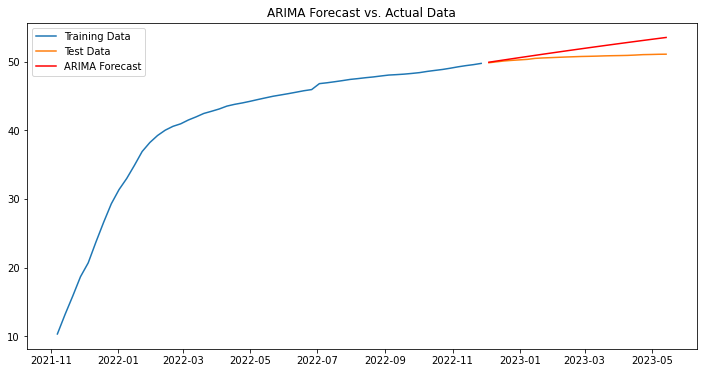

In [49]:
# seatch range
model = auto_arima(train_data, start_p=1, start_q=1,
                           max_p=10, max_q=10,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

best_order = model.get_params()['order']
p, d, q = best_order
final_model = ARIMA(train_data, order=(p, d, q))
final_model_fit = final_model.fit()
n_forecast = len(test_data)
forecast = final_model_fit.forecast(steps=n_forecast)
rmse = sqrt(mean_squared_error(test_data, forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(test_data.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs. Actual Data')
plt.show()

### AUTO ARIMA with lag

In [76]:

# Train AutoARIMA model with exogenous variables
model = auto_arima(train_data[pred_var], exogenous=train_data[['lag_1']],
                   start_p=0, 
                   start_q=0,
                   start_d =0,
                   max_p=10,
                   max_q=10,
                   max_d =10,
                   start_P=0,
                   max_P = 10,
                   seasonal=True,
                   start_D =0,
                   max_D = 10,
                   m=12, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

# Make predictions
forecast, conf_int = model.predict(n_periods=len(test_data), exogenous=test_data[['lag_1', 'lag_2']], return_conf_int=True)

rmse = sqrt(mean_squared_error(test_data[pred_var], forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=18.365, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=18.945, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=16.785, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=17.027, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=17.510, Time=0.01 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=18.782, Time=0.11 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=18.782, Time=0.05 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=16.966, Time=0.02 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=20.782, Time=0.10 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=18.282, Time=0.02 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=18.781, Time=0.04 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=18.775, Time=0.05 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=16.880, Time=0.03 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=20.767, Time=0.07 sec
 ARIMA(1,2,0)(1,0,0)[12] intercept   : AIC=16.6

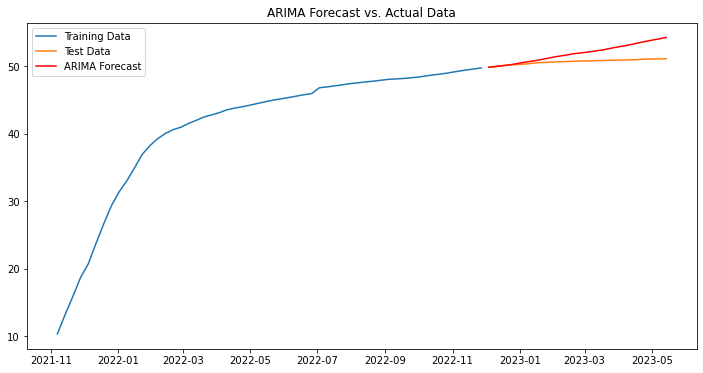

In [70]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data[pred_var], label='Training Data')
plt.plot(test_data[pred_var], label='Test Data')
plt.plot(test_data.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs. Actual Data')
plt.show()